# Maximum Entropy Inverse Reinforcement Learning

Based on the paper of the same name by Brian D. Ziebart

## Introduction

The Inverse Reinforcement Learning Problem is defined as follows:

Given 
* Markov Decision Process (S, A, T, r, $\gamma$)
* Dataset $\mathcal{D} = \{ \tau_1, \tau_2, ...\}$
* and Expert Trajectories $\tau = ((s_1, a_1), (s_2, a_2), ...)\in \mathcal{D}$

find the reward function $r(s)$ that results in an optimal policy $\pi$ that generates the Expert Trajectories $\mathcal{D}$.

This ambiguity needs to be resolved to make IRL a well-defined optimization problem.
The approach presented by Ziebart strives to solve this problem by framing it as a Constrained Optimization Problem. The Entropy of the resulting Trajectory Distribution is maximized, while enforcing matching feature expectations to Expert Trajectories.

In [1]:
import numpy as np
import gym
import os
import time
from itertools import product
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Utility Functions

In [2]:
def to_onehot(state, num_states):
    """
    represent a state as a vector
    can be interpreted as a mapping from state to feature
    
    example: f(1,4) -> (0,1,0,0)
             f(3,4) -> (0,0,0,1)
    
    state:       integer representing the current state
    num_state:   total number of states
    """
    result = np.zeros(num_states)
    result[state] = 1
    return result

def softmax1D(vec: np.ndarray):
    """
    compute the softmax of vec
    """
    transformed_vec = vec - np.max(vec)
    numerator = np.exp(transformed_vec)
    denominator = np.sum(numerator)
    return numerator/denominator

def visualize_policy(policy, other_policy=None):
    left = "\u2190"
    down = "\u2193"
    right = "\u2192"
    up = "\u2191"
    action_map = [left,down,right,up]
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            arrow = action_map[policy[i,j]]
            if other_policy is not None:
                if policy[i,j]!=other_policy[i,j]: arrow = '\x1b[6;30;42m'+arrow+'\x1b[0m'
            print(arrow, end=" ")
                
        print("")

def plot_reward(reward, text=True, use_hsv=False, vrange=None):
    """ 
    Function from https://github.com/humans-to-robots-motion/rl-course/blob/master/ex05-td/ex05-td.py
    Adapted to plot reward and visualize environment
    
    reward:   reward for each state
    env:      gym environment
    text:     whether to add values as text
    use_hsv:  whether to use hsv color map
    """
    fig = plt.figure()
    
    dims = (8,8)
    reward_reshaped = np.zeros(dims)
    for s in range(len(reward)):
        idx = np.unravel_index(s, dims)
        reward_reshaped[idx] = np.max(reward[s])
    
    min_r = np.min(reward_reshaped)
    max_r = np.max(reward_reshaped)
    
    if vrange is not None:
        min_r, max_r = vrange
    
    colormap = plt.cm.hsv if use_hsv else plt.cm.RdYlGn
    
    plt.imshow(reward_reshaped, origin='upper', 
               extent=[0,dims[0],0,dims[1]], vmin=min_r, vmax=max_r, 
               cmap=colormap, interpolation='none')
    
    if text:
        for x, y in product(range(dims[0]), range(dims[1])):
            plt.text(y+0.5, dims[0]-x-0.5, '{:.2f}'.format(reward_reshaped[x,y]),
                    horizontalalignment='center', 
                    verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

def plot_frozenlake_8x8():
    """
    Plot a visual representation of the FrozenLake8x8 environment
    """
    env_map = np.arange(env.num_states).reshape((8,8))
    env_map[[1,3,5,7]] += 1
    env_map %= 2
    env_map = np.array(env_map, dtype=float)
    env_map *= 0.01
    env_map += 0.35
    
    env_map = env_map.flatten()
    env_map[env.terminal_states] = 0.8
    env_map[env.num_states-1] = 0.2
    env_map[0] = 0.1
    
    plot_reward(env_map, text=False, use_hsv=True, vrange=(0.0,0.6))

def value_iteration(env, reward_fn=None, gamma = 0.99, delta_threshold = 0.001):
    """
    env:              environment implementing gym interface, with added attributes
                      (num_states, num_actions, P, terminal_states)
    reward_fn:        function(state,action) -> reward
                      if None: use reward function of environment
    gamma:            discounting factor
    delta_threshold:  stopping criterion based on update magnitude
    """
    num_states = env.num_states
    num_actions = env.num_actions
    P = env.P
    terminal_states = env.terminal_states
    
    delta = np.inf
    
    max_iter = 10000
    count = 0
    V = np.zeros(num_states)
    while not delta < delta_threshold and count < max_iter:
        delta = 0
        for state in range(num_states):
            if state in terminal_states:
                continue
            
            old_v = V[state]
            
            # for each action calculate value
            action_vals = np.zeros(num_actions)
            for action in range(num_actions):
                action_val = 0
                for prob, next_state, reward, _ in P[state][action]:
                    if reward_fn is not None:
                        reward = reward_fn(next_state, action)
                    action_val += prob*(reward+gamma*V[next_state])
                action_vals[action] = action_val
            
            V[state] = np.max(action_vals)
            delta = max((delta, np.abs(old_v-V[state])))
            
        count += 1

    return V

def stochastic_policy_from_values(V, P, gamma, num_states, num_actions, reward_fn=None):
    """
    compute a stochastic policy given the value function
    this is done by computing the softmax on the q-values to get a probability distribution over actions
    
    V:          Value Function
    P:          State-Action Transition Probabilities
    gamma:      discounting factor
    num_states: total number of states
    reward_fn:  f(state,action)->reward
                if None: use reward function of environment
    """
    Q = np.zeros((num_states,num_actions))
    policy = np.zeros((num_states,num_actions))
    for state in range(num_states):
        for action in range(num_actions):
            for prob, next_state, reward, done in P[state][action]:
                if reward_fn is not None:
                    reward = reward_fn(next_state, action)
                Q[state][action] += prob*(reward+gamma*V[next_state])
        
        policy[state] = softmax1D(Q[state])
    return policy
    

def deterministic_policy_from_values(V, P, gamma, num_states, num_actions, reward_fn=None):
    """
    compute a deterministic, greedy policy given the value function
    always choses the stochastic action with the highest probability
    
    V:          Value Function
    P:          State-Action Transition Probabilities
    gamma:      discounting factor
    num_states: total number of states
    reward_fn:  f(state,action)->reward
                if None: use reward function of environment
    """
    stochastic_policy = stochastic_policy_from_values(V, P, gamma, num_states, num_actions, reward_fn=reward_fn)
    return np.argmax(stochastic_policy, axis=1)
    

## Computing State Visitation Frequencies

State Occupancy Frequencies for the current reward function are required to compute the Gradient for Maximizing the Log Likelihood of the trajectories conditioned on the reward weights.  

The gradient looks like this:

$ \displaystyle L_\theta = \tilde{f} - \sum_\tau {P(\tau | \theta) f_\tau}$

However, it is not feasible to sum over all trajectories. By summing over the finite set of states the problem can be avoided:

$ \displaystyle L_\theta = \tilde{f} - \sum_s {D_s f_s}$

The new Gradient Equation now requires the expected state occupancy frequncies $D_s$.  
They can be computed efficiently using a forward-backward algorithm that is similar to Value Iteration.  

In the first three steps, a stochastic policy or probability distribution actions, conditioned on the state is computed.
First, factors for state ocurrences Zs are initialized by assigning one to all terminal states:
$Z_{s_{terminal}} = 1$.  
The next step is the backward pass:  
$ \displaystyle Z_{a_{i,j}} = \sum_k P(s_k | s_i, a_{i,j}) e^{r_\theta(s_i)} Z_{s_k}$  
$ \displaystyle Z_{s_i} = \sum_{a_{i,j}} Z_{a_{i,j}} + [s_i \in S_{terminal}]$  
Intuitively, the weight $e^{r_\theta(s_i)}$ makes coming from a higher reward state $s_i$ into $s_k$ more likely compared to lower reward states, as $s_i$ has a higher weight.

Due to summing over exponentiated reward values for multiple iterations, overflows can occurr. To mend this problem to a certain degree, the factors are normalized after every step.

Finally, one can derive a stochastic policy by normalizing $Z_{a_{i,j}}$ using $Z_{s_i}$ for each state-action pair:  
$ \pi(a_{i,j}|s_i) = \frac{Z_{a_{i,j}}}{Z_{s_i}}$  

As this method does not perform well on FrozenLake, it was replaced by value iteration. Taking the softmax over the q-values of each state produces the stochastic policy.

During the last three steps, the state occupancy frequencies D_{s,t} are calculated in a forward pass, making use of the previously calculated policy. 
$D_{s_i,t=0}=P(s_i = s_{initial})$  
$ D_{s_k,t+1} = \sum_{s_i}\sum_{a_{i,j}} D_{s_i,t} \pi(a_{i,j}|s_i) P(s_k | s_i, a_{i,j}) $  
This results in the state occupancy frequencies for each timestep, where timestep zero corresponds to the initial state distribution. Accumulating the frequencies over all timsteps yields the overall state occupancy frequncies.  
$\displaystyle D_{s_i} = \sum_t D_{s_i,t}$

These are normalized by the sum of all vector entries (same as multiplying with $\frac{1}{num\_timesteps})$ to get a probability distribution.

In [3]:
def compute_state_visitation_frequencies(env, reward_fn, iterations = 200, use_paper_backward_pass=False):
    """
    compute state visitation frequencies based on the transition probabilities P of environment env and terminal states
    """
    
    P = env.P
    num_states = env.num_states
    num_actions = env.num_actions
    terminal_states = env.terminal_states
    initial_Ps = env.initial_Ps  

    # use backward pass from paper
    if use_paper_backward_pass:
        
        # step 1: initialize factors

        # factor Zs initially corresponds to terminal state distribution
        Zs_final = np.zeros(num_states)
        Zs_final[terminal_states] = 1 
        Zs = np.zeros(num_states)
        Zs[terminal_states] = 1

        # factor Za is initialized by the backward pass from Zs
        Za = np.zeros((num_states, num_actions))

        # step 2: backward pass
        for _ in range(iterations):

            # update Za based on state-factors Zs
            for state in range(num_states):
                for action in range(num_actions):

                    Za[state, action] = sum(
                            [prob*(np.e**(reward_fn(state,action)))*Zs[next_state]
                                for prob, next_state, _, done in P[state][action]]
                        )

            # normalize factor to prevent overflow
            Za /= np.sum(Za)

            # update Zs by summing over state-action factors Za
            Zs = np.zeros(num_states)
            for state in range(num_states):
                for action in range(num_actions):
                    Zs[state] += Za[state, action]

                Zs[state] += Zs_final[state]

            # normalize factor to prevent overflow
            Zs /= np.sum(Zs)


        # step 3
        # Local action probability computation
        P_sa = np.array([
                [Za[state, action]/Zs[state] for action in range(num_actions)]
                for state in range(num_states)
            ])
        P_sa = P_sa/np.sum(P_sa, axis=1)[:,None]

        policy = np.argmax(P_sa, axis=1)
    
    # use value iteration for backward pass
    else:
        gamma = 0.999
        V = value_iteration(env, reward_fn=reward_fn, gamma = gamma, delta_threshold = 0.01)
        P_sa = stochastic_policy_from_values(V, P, gamma, num_states, num_actions, reward_fn=reward_fn)
        # when using deterministic policy:
        # policy = deterministic_policy_from_values(V, P, gamma, num_states, num_actions, reward_fn=reward_fn)

    # step 4
    # set D at timestep 0 initial state distribution
    timesteps = 200
    D = np.zeros((timesteps, num_states))
    D[0] = initial_Ps
    
    
    # Delete this
    #print("start")
    #print(P_sa)
    #visualize_policy(policy.reshape(8,8))
    
    # step 5: forward pass
    # calculate visitation frequences at each timestep
    for t in range(timesteps-1):
        
        for state_i in range(num_states):

            for action in range(num_actions):
                
                for p_sas, state_k, _, done in env.P[state_i][action]:
                    
                    # go from state_i to state_k
                    # old paper suggests D[t+1, state_i] += ( D[t, state_k] * P_sa[state_i, action] * p_sas )
                    # correct version of paper on bziebarts homepage:
                    D[t+1, state_k] += ( D[t, state_i] * P_sa[state_i, action] * p_sas )
                    # Version using deterministic policy:
                    # D[t+1, state_k] += ( D[t, state_i] * (policy[state_i] == action) * p_sas )
                    
                    #if t < 4 and p_sas != 0 and D[t, state_i] != 0:
                    #    print(f"from state:{state_i}, action:{action}, next_state:{state_k}, policy[state_i]={policy[state_i]}, equal to action: {(policy[state_i] == action)*1}")
                     
        
        # Delete this
        #plot_reward(D[t+1], env)
        #plt.show()
        
    # Delete this
    #plot_reward(D[t+1], env)
    #plt.show()
        
    # step 6: marginalize over time
    Ds = np.sum(D, axis=0)

    # normalize state visitation frequencies
    Ds = Ds / np.sum(Ds)

    return Ds

## Expert Feature Expectation

Revisiting the computation of the Gradient of the Trajectory Log-Likelihood, one component is still missing:  
$ \displaystyle L_\theta = \tilde{f} - \sum_s {D_s f_s}$  

The Expert Empirical Feature Expectations $\tilde{f}$ are computed by summing over the accumulated features $f_\tau$ of all trajectories $\tau$:  
$f_\tau = \sum_{s_t \in \tau} f_{s_t}$  
$ \tilde{f} = E_{P(\tau)}[f_\tau] = \sum_{\tau} P(\tau) f_\tau \approx \frac{1}{|\mathcal{D}|} \sum_{\tau \in \mathcal{D}} f_\tau$

As not all trajectories have the same length, the length of the longest trajectory is set as the duration of the outer loop (in case of FrozenLake the limits is 200 timesteps). For shorter trajectories, the last state of the trajectory is a terminal state that the agent is staying at for the remaining amount of time. This is in line with the forward pass for state occupancy computation, where the probability mass is shifting to terminal states over the same number of timesteps.  

Finally, the feature expectations are normalized over the number of expert trajectories and the number of timesteps to be comparable with the results of the state occupancy calculation.

In [4]:
def calculate_expert_feature_expectation(expert_trajectories, feature_fn, feature_len):
    """
    expert_trajectories: [(action_1, reward_1, obs_1),...,(action_n, reward_n, obs_n)]
    feature_fn           function(state)->feature
    feature_len:         length of the feature vector
    """
    T = len(max(expert_trajectories,key=lambda x: len(x)))
    expert_feature_expectations = np.zeros(feature_len)
    
    for trajectory in expert_trajectories:
        trajectory_feature_expectation = np.zeros(feature_len)
        for t in range(T):
            expert_feature_expectations += feature_fn(trajectory[t if t<len(trajectory) else -1][2])
    
    return expert_feature_expectations / (len(expert_trajectories)*T)

## Maximum Entropy IRL Algorithm

Having seen the components of the gradient update, the Gradient Ascend update of the reward weights can be assembled.  

The following steps are taken to update the reward weights:

1. Initialize reward function weights $\theta$  
2. Calculate the Empirical Feature Expectation $\tilde{f}$ of the Expert Trajectories  
Repeat:  
3. Calculate a (stochastic) policy $\pi$ according to the current approximation of the reward function
4. Calculate the State Visitation Frequencies $P(s|\theta,T)$ for $\pi$
5. Update the rewards weights $\theta$ by Gradient Ascend on the Log Likelihood of the Expert Trajectories:  
  $\theta_{t+1} = \theta_t +  \alpha \frac{1}{|\mathcal{D}|} (\tilde{f} - \sum_{s \in S}  P(s | \theta, T) f_s)$

In [5]:
def max_ent_irl(env, reward_weights, reward_fn, feature_fn, expert_demonstrations, num_gradient_steps = 100):
    """
    env:    environment implementing the OpenAI gym interface
            needs to have:
                - fixed set of discrete states
                - fixed set of discrete actions
                - env.P: fixed discrete transition probability distribution over states and actions
    
    reward_weights:        weights used in the reward function, len(reward_weights) = len(feature)
    reward_fn:             function(state, action) -> reward
    feature_fn:             
    expert_demonstrations: [(action_1, reward_1, obs_1),...,(action_n, reward_n, obs_n)]

    return: reward_weights of linear reward function
    """
    
    # environment properties
    num_states = env.num_states
    num_actions = env.num_actions
    terminal_states = env.terminal_states
    initial_Ps = env.initial_Ps
    
    # verbose
    plot_progress = False
    track_progress = True
    gradient_norms = []
    
    feature_len = len(reward_weights)

    expert_feature_expectation = calculate_expert_feature_expectation(
                                    expert_demonstrations, feature_fn, feature_len)

    
    def step_size(step):
        return 1
    
    def plot_progress_fn(step, gradient, expert_feature_expectation, current_feature_expectation):
        print("expert feature expectation")
        plot_reward(expert_feature_expectation, env, vrange=(0,0.6))
        plt.show()
        print("learner feature expectation")
        plot_reward(current_feature_expectation, env, vrange=(0,0.6))
        plt.show()
        irl_reward = [reward_fn(state,0) for state in range(env.num_states)]
        print("reward")
        plot_reward(irl_reward, env)
        plt.show()
    
    for step in range(num_gradient_steps):
        
        # computing the expert feature expectations
        D = compute_state_visitation_frequencies(env, reward_fn)
        
        # computing the current feature expectations
        current_feature_expectation = sum([D[state]*feature_fn(state) for state in range(num_states)])
        
        # the gradient is the difference of expert feature expectations and current feature expectations
        gradient = expert_feature_expectation - current_feature_expectation
        
        # gradient ascend step
        reward_weights[:] += step_size(step) * gradient
        
        if track_progress:
            clear_output(wait=True)
            print(f"Progress: {step/num_gradient_steps : 6.5f}, Gradient L1 Norm: {np.sum(np.abs(gradient)) : 6.5f}")
            gradient_norms.append(np.sum(np.abs(gradient)))
            
        if plot_progress:
            plot_progress_fn(step, gradient, expert_feature_expectation, current_feature_expectation)
            
    if track_progress:
        clear_output(wait=True)
        plot_progress_fn(step, gradient, expert_feature_expectation, current_feature_expectation)
        print("L1 norm of the gradient (difference of expert and learner feature expectations)")
        plt.plot(gradient_norms)
        plt.show()
    
    return reward_weights

## Generating Rollouts using (Optimal) Policy

In order to generate the expert trajectories, a policy is calculated using Value Iteration.
The expert policy is calculated from the True Reward Function, making it optimal with respect to the true reward function and the given discounting factor $\gamma=0.99$.  
After computing the expert policy, it can be rolled out on the environment, producing the dataset of expert trajectories.  
The dataset $\mathcal{D}$ is a list of expert trajectories of the following form:  
$((-, -, s_0), (a_1, r_1, s_1), \ldots, (a_n, r_n, s_n)) \in \mathcal{D}$

In [6]:
def generate_rollouts(env, policy, num_rollouts=10, render=False, render_fps=2):
    """
    generate rollouts on env with specified policy 
    
    env:           gym environment
    policy:        policy of the agent, list containing actions for each state
    num_rollouts:  number of rollouts to generate
    render:        if set True, animate the rollout
    render_fps:    delay between steps is 1/render_fps
    
    return:        rollouts following the specified policy of follwing format:
                   [(action_1, reward_1, obs_1),...,(action_n, reward_n, obs_n)]
    """
    expert_demonstrations = []
    for _ in range(num_rollouts):
        done = False
        obs = env.reset()
        trajectory = [(None, None, obs)]
        while not done:
            action = policy[obs]
            obs, reward, done, info = env.step(action)
            if render:
                clear_output(wait=True)
                env.render()
                time.sleep(1/render_fps)
                
            trajectory.append((action, reward, obs))
        expert_demonstrations.append(trajectory)
    
    return expert_demonstrations

def get_expert_demos_valiter(env):
    """
        finds the optimal policy for env using value iteration
        
        env:    gym environment
        
        return: rollouts using the optimal policy of following format:
                [(action_1, reward_1, obs_1),...,(action_n, reward_n, obs_n)]
    """
    num_actions = env.num_actions
    num_states = env.num_states
    gamma = 0.999
    V = value_iteration(env,gamma=gamma)
    policy = deterministic_policy_from_values(V, env.P, gamma, num_states, num_actions)
    return generate_rollouts(env, policy, num_rollouts=100), policy

## Creating the FrozenLake environment

The FrozenLake8x8-v0 environment was chosen as a challenging stochastic environment.  
Additional helper variables are added to simplify the code and avoid redefinition.

In [7]:
# run maximum entropy inverse reinforcement learning on FrozenLake8x8
env = gym.make("FrozenLake8x8-v0")
env.num_states = 64
env.num_actions = 4
env.terminal_states = [19, 29, 35, 41, 42, 46, 49, 52, 54, 59, 63]
env.initial_Ps = np.zeros(env.num_states)
env.initial_Ps[0] = 1

## Defining Feature Functions

Feature functions are used to map integer-valued state to vector-valued features.
Two different feature functions are defined:  

The ```onehote_feature_fn``` encodes each state as onehot vector with the size of the features.  
Example:  

    num_states = 5
    state = 3
    onehot_feature_fn(state, num_states) == [0,0,0,1,0]
    
The ```neighbor_feature_fn``` encodes the currently occupied state and the four neighboring states as a onehot-representation of their types.
Example assuming only 3 types H, F and G:  

    neighbors:
     
        F
     F *H* H
        G
    
    H corresponds to [1,0,0]
    G corresponds to [0,1,0]
    F corresponds to [0,0,1]
    
                                    center, H  left, F  right, H  left, F  bottom, G
    neighbor_feature_fn(state) = [  1,0,0,     0,0,1,   1,0,0,    0,0,1,   0,1,0      ]
    
However, this feature function produced low agent success rates around $30\%$ hence it is not evaluated here.

In [8]:
feature_len = 64
# for neighbor feature function:
# feature_len = 25

reward_weights = np.zeros(feature_len)
    
def onehot_feature_fn(state):
    return to_onehot(state, feature_len)

def neighbor_feature_fn(state):
    row = int(state % 8)
    col = int(state // 8)
    
    mapping = {b"S": 0, b"F": 1, b"H":2, b"G":3}
    num_types = 5
    
    center = mapping[env.unwrapped.desc[row,col]]
    if col < 1:
        left = 4
    else:
        left = mapping[env.unwrapped.desc[row,col-1]]
    
    if col > 6:
        right = 4
    else:
        right = mapping[env.unwrapped.desc[row,col+1]]
    
    if row < 1:
        top = 4
    else:
        top = mapping[env.unwrapped.desc[row-1,col]]
        
    if row > 6:
        bottom = 4
    else:
        bottom = mapping[env.unwrapped.desc[row+1,col]]
    
    feature_vec = np.concatenate((to_onehot(center, num_types), 
                                  to_onehot(left, num_types),
                                  to_onehot(right, num_types),
                                  to_onehot(top, num_types),
                                  to_onehot(bottom, num_types)))
    
    return feature_vec

                          
feature_fn = onehot_feature_fn

## Defining the Linear Reward Function
The reward function is defined as linear combination of reward weights and state-features:  
$r(s) = w^T f_s$

In [9]:
def reward_fn(state,action):
        return reward_weights.T@feature_fn(state)

## Generating Expert Demonstrations
This cell gathers the expert trajectories and returns them, alongside the expert policy.

In [10]:
expert_demos, expert_policy = get_expert_demos_valiter(env)

## Learning the Reward Weights using Maximum Entropy IRL
The following cell executes the maximum entropy algorithm implementation to fit the reward weights.  

Warning:  
This takes quite some time to converge. 
The L1 Norm of the gradient is decreased to less than 0.2 after 300 gradient steps.
This process took 12 minutes on an Intel i5 2400 Desktop Processor from 2011.

After the computation, expert and learner feature expectations are plotted, which match quite well.
The largest difference can be observed at the goal state. Adding more optimization steps decreases the difference.  
The decrease in the L1 norm of the difference in expert and learner feature expectations is displayed in the plot at the bottom of the output.

expert feature expectation


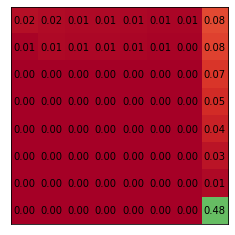

learner feature expectation


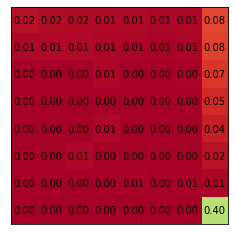

reward


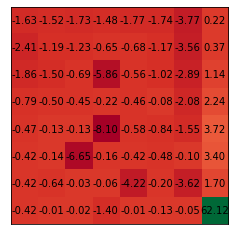

L1 norm of the gradient (difference of expert and learner feature expectations)


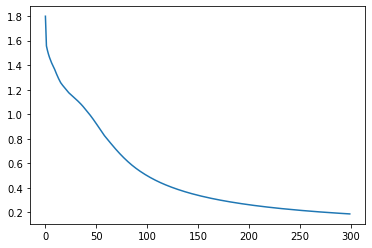

In [11]:
reward_weights = max_ent_irl(env, reward_weights, reward_fn, feature_fn, expert_demos, num_gradient_steps=300)

## Inferring a policy from the Learned Reward Function
Value Iteration is used to retrieve the policy from the learned reward function.

In [12]:
gamma = 0.999
V = value_iteration(env, reward_fn=reward_fn, gamma=gamma)
resulting_policy = deterministic_policy_from_values(
                        V, env.P, gamma, env.num_states, env.num_actions, reward_fn=reward_fn)

## FrozenLake 8x8 environment

This cell shows the Frozenlake8x8-v0 envrionment.
The yellow square represents the starting state and the green one the goal state.  
Using the actions up, down, left and right, the agent can move to any of the up to four adjacent states.
However, the agent slips with chance of $\frac{2}{3}$ and executes one of the two actions that are orthogonal to the original one.  
For example, if the agent takes the action up, he may end up in states left or right of the current state with a probability of $\frac{1}{3}$ each. 

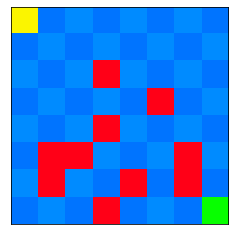

In [13]:
plot_frozenlake_8x8()

# Reward Function Comparison

In [14]:
import matplotlib.pyplot as plt
feature_matrix = np.eye(env.num_states, env.num_states)

irl_reward = [reward_fn(state,0) for state in range(env.num_states)]

true_reward = np.zeros(64)
true_reward[63] = 1

The following two cells show the learned reward function (top) and the true reward function (bottom).  

Observations:
* The goal state has the highest reward in both cases
* States on the right border have smaller positive values
* The remaining states have negative rewards
* Negative rewards are especially large on some of the holes


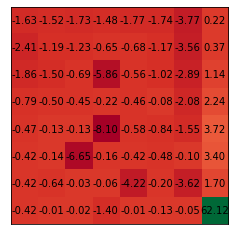

In [15]:
plot_reward(irl_reward)

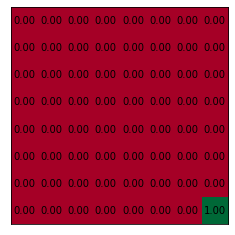

In [16]:
plot_reward(true_reward)

## Policy Comparison

The cell at the top shows the policy derived from the learned reward function, while the cell below shows the expert policy. Differences in the policies are marked in green.  

Overall, the learner-policy matches the expert policy well. States with different policies are barely visited and are not impactful.

In [17]:
visualize_policy(resulting_policy.reshape((8,8)), other_policy=expert_policy.reshape(8,8))

↑ → → → → → → → 
↑ ↑ ↑ ↑ ↑ ↑ → → 
↑ ↑ ← ← → ↑ → → 
↑ ↑ ← ↑ ← ← → → 
← ↑ ← ← → ↓ ↑ → 
← ← ← ↓ ↑ ← ← → 
← ← ↓ ← ← → ← → 
← ↓ ← ← ↓ → ↓ ← 


In [18]:
visualize_policy(expert_policy.reshape(8,8))

↑ → → → → → → → 
↑ ↑ ↑ ↑ ↑ ↑ → → 
↑ ↑ ← ← → ↑ → → 
← ← ← ↓ ← ← → → 
← ↑ ← ← → ↓ ↑ → 
← ← ← ↓ ↑ ← ← → 
← ← ↓ ← ← ← ← → 
← ↓ ← ← ↓ → ↓ ← 


This is also apperent when comparing the ratio of successful episodes to total episodes over 1000 rollouts.
Despite the policies not matching perfectly, expert and learner success rates are comparable. Both expert and learner achieve high percentages of successful episodes over 80%.

In [19]:
number_of_rollouts = 1000
rollouts = generate_rollouts(env, expert_policy, num_rollouts=number_of_rollouts)
print(f"Expert success rate = {sum([rollout[-1][1] for rollout in rollouts])/number_of_rollouts}")
rollouts = generate_rollouts(env, resulting_policy, num_rollouts=number_of_rollouts)
print(f"IRL success rate = {sum([rollout[-1][1] for rollout in rollouts])/number_of_rollouts}")

Expert success rate = 0.885
IRL success rate = 0.888


## Animation of the resulting policy

The cell below can be executed to animate the execution of the learner policy on the environment.

In [21]:
# animate resulting policy
_ = generate_rollouts(env, resulting_policy, num_rollouts=1, render=True, render_fps=10)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


# Changes made after the presentation:

After the discussion of the project presentation, i made some changes to account for the criticism:

* Calculate backward pass using value iteration instead of the version from the paper
* Choose gamma 0.999 instead of 0.99
* More optimization steps

Resulting improvements (compare to slides):
* Better convergence of feature expectations of learner to expert (small L1 norm of gradient, visualization similar)
* Holes mostly have high negative rewards
* Smaller gap between learner and expert success rate